In [14]:
# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

#for easy access to path
import sys
import os

#importing packages for data manuplation and visualization
import numpy as np
import pandas as pd
import math

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import ticker
from statsmodels.tsa.stattools import adfuller, acf, pacf

# Visualization Configuration
%matplotlib inline
sns.set()

In [2]:
#Acessing scripts and data path
sys.path.append(os.path.abspath(os.path.join('data')))
sys.path.insert(0,'../scripts/')

In [3]:
#import sklearn
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
import mlflow

In [4]:
#import local libraries
from clean_train_test_df import CleanStoreDf
from data_preview import DataPreview
from data_loader import load_df_from_csv
from data_manipulation import DataManipulator
from plots import *
from result import ResultPicker
from sklearn import preprocessing

results = ResultPicker()

In [6]:
#reading our data
pd.set_option('max_column', None)
pd.set_option('max_rows', None)

clean_df= pd.read_csv('../data/store_train_merged.csv')

In [7]:
#grouping by date
clean_df = clean_df[['Date','Sales']]
clean_df = clean_df.groupby('Date').agg({'Sales':'mean'})

In [8]:
clean_df.head()

,Sales
Date,
2013-01-01,87.284560
2013-01-02,6233.030493
2013-01-03,5693.112108
2013-01-04,5954.218834
2013-01-05,5337.751570


## <font color='darkolivegreen'>Scaling</font>

In [9]:
#creating object
manip = DataManipulator(clean_df, deep=True)

In [10]:
#scaling
manip.minmax_scale_columns(['Sales'], range_tup=(-1,1)).head()

,Sales
Date,
2013-01-01,-1.000000
2013-01-02,-0.117299
2013-01-03,-0.194846
2013-01-04,-0.157344
2013-01-05,-0.245886


## <font color='darkolivegreen'>Time Series Analysis</font>

In [12]:
clean_data=CleanStoreDf(clean_df)
scaled_df =clean_data.optimize_df()

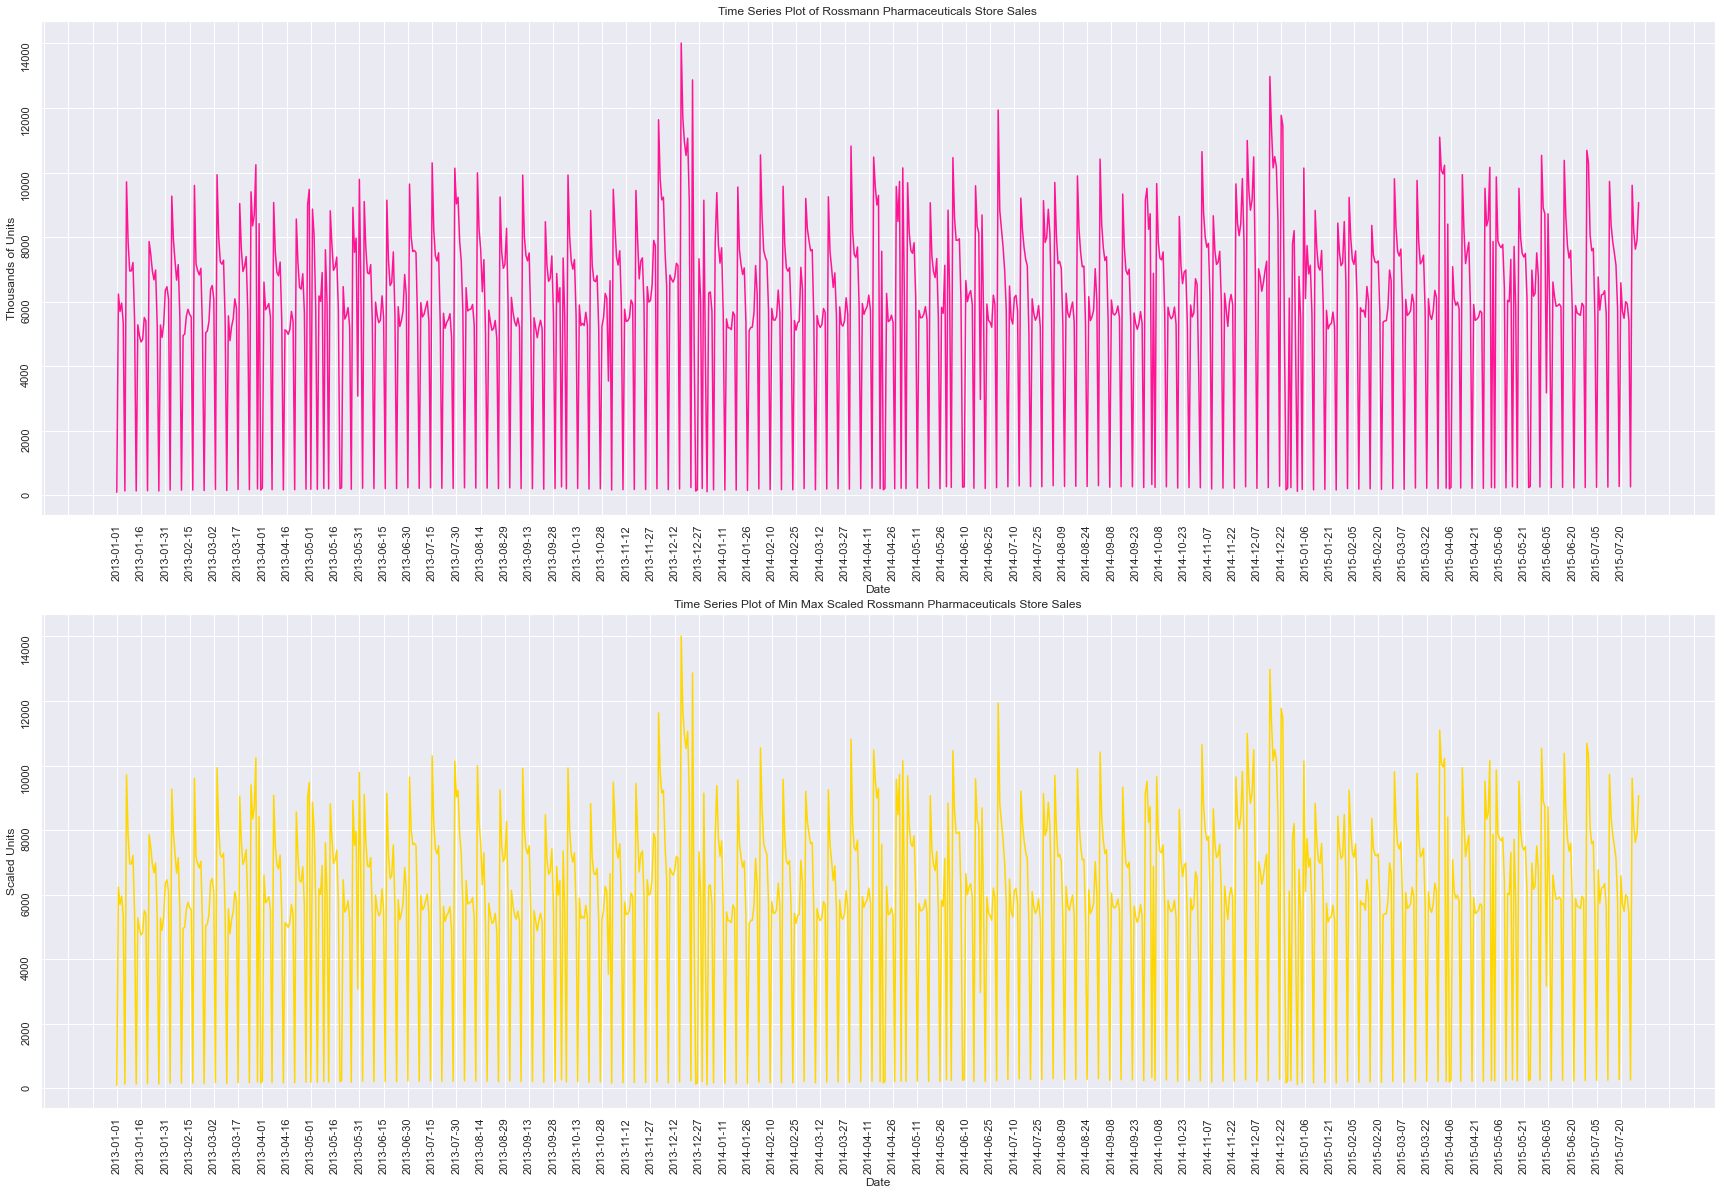

In [59]:
fig = plt.figure()
gs = GridSpec(2, 1, figure=fig)

fig.set_figheight(20)
fig.set_figwidth(30)
fig.tight_layout(pad=10)

#creating ticks object with M ticks
M = 100 
xticks = ticker.MaxNLocator(M)

ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(clean_df.index, clean_df.Sales, 'deeppink')
ax1.xaxis.set_major_locator(xticks)
ax1.tick_params(labelrotation=90)
ax1.set_xlabel('Date')
ax1.set_ylabel('Thousands of Units')
ax1.title.set_text('Time Series Plot of Rossmann Pharmaceuticals Store Sales')
ax1.grid(True)

ax2 = fig.add_subplot(gs[1, 0])
ax2.plot(scaled_df.index, scaled_df.Sales, 'gold')
ax2.xaxis.set_major_locator(xticks)
ax2.tick_params(labelrotation=90)
ax2.set_xlabel('Date')
ax2.set_ylabel('Scaled Units')
ax2.title.set_text(
    'Time Series Plot of Min Max Scaled Rossmann Pharmaceuticals Store Sales')
ax2.grid(True)
plt.show()

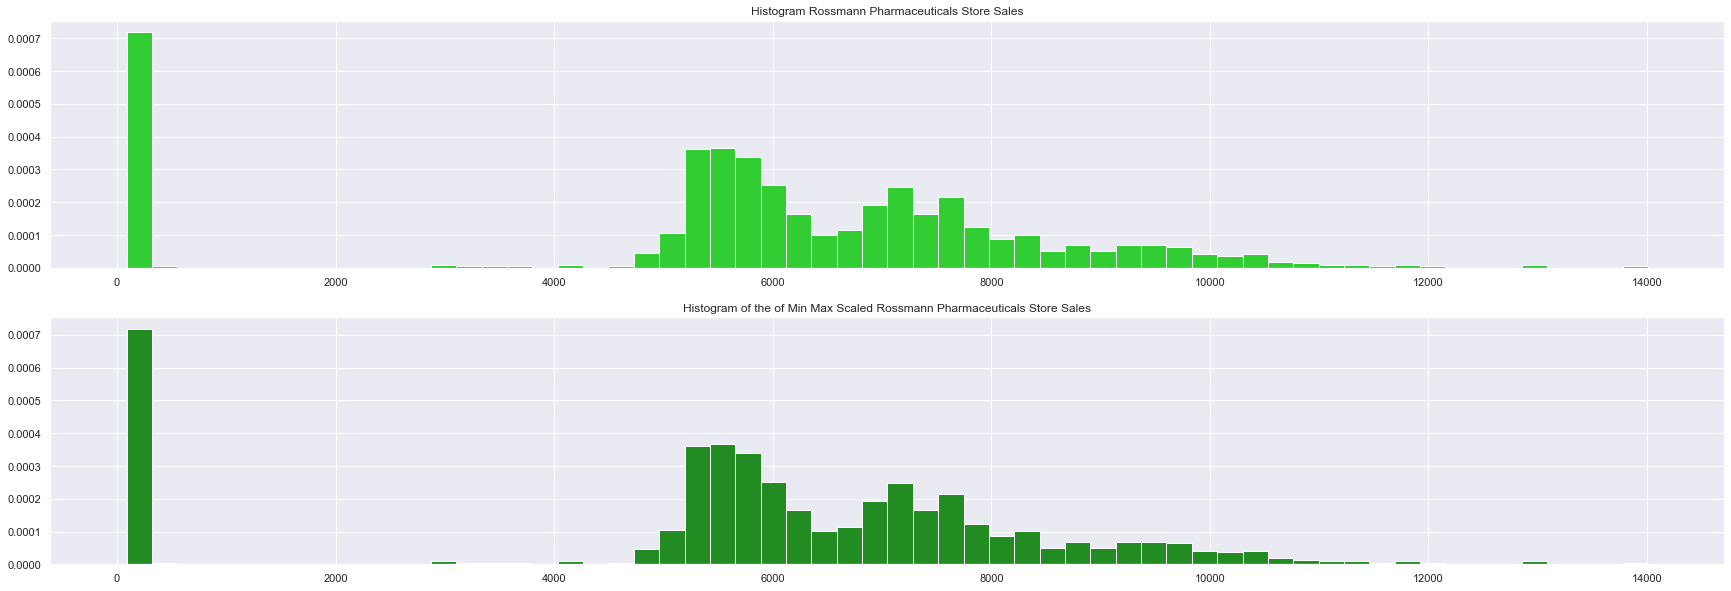

In [61]:
#ploting histogram
fig = plt.figure()
gs = GridSpec(2, 1, figure=fig)

fig.set_figheight(10)
fig.set_figwidth(30)
fig.tight_layout(pad=6)

ax1 = fig.add_subplot(gs[0, 0])
ax1.hist(clean_df.Sales, density=True, bins=60,color='limegreen')
ax1.title.set_text('Histogram Rossmann Pharmaceuticals Store Sales')
ax1.grid(True)

ax2 = fig.add_subplot(gs[1, 0])
ax2.hist(scaled_df.Sales, density=True, bins=60,color='forestgreen')
ax2.title.set_text('Histogram of the of Min Max Scaled Rossmann Pharmaceuticals Store Sales')
ax2.grid(True)
plt.show()

In [62]:
scaled_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 942 entries, 2013-01-01 to 2015-07-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Sales   942 non-null    float32
dtypes: float32(1)
memory usage: 11.0+ KB


In [63]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

In [64]:
sales_difference = difference(scaled_df.Sales.values)

In [65]:
#Check for autocorrelation and partial autocorrelation of your data
def corrPlots(array: np.array, prefix: str):
    plt.figure(figsize=(30, 5))
    plt.title(
        f"{prefix}  Autocorrelations of Scaled Rossmann Pharmaceuticals Store Sales Min Max Scaled")
    plt.bar(range(len(array)), array)
    plt.grid(True)
    plt.show()

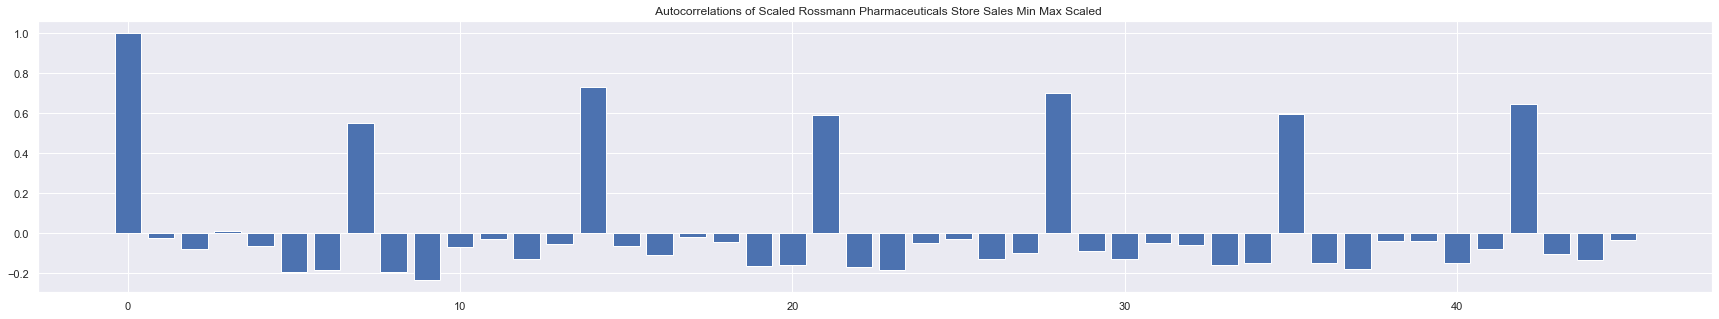

In [69]:
# AutoCorrelation
acfSalesScaled = acf(scaled_df.Sales.values, fft=True, nlags=45,)
acfSalesScaledNp = np.array(acfSalesScaled)
corrPlots(acfSalesScaledNp, '')

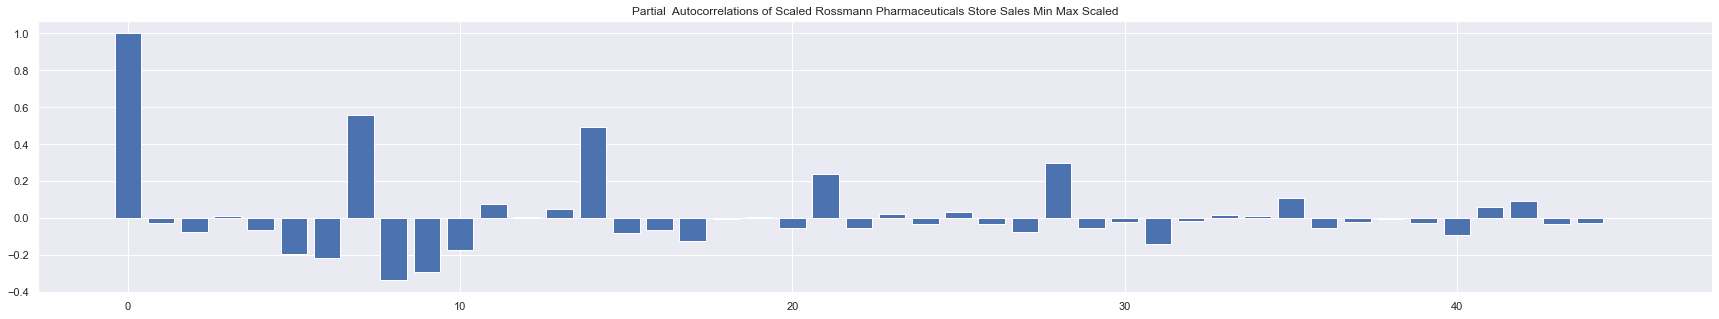

In [70]:
# Partial Correlation
pacfSalesScaled = pacf(scaled_df.Sales.values, nlags=45)
pacfSalesScaledNp = np.array(pacfSalesScaled)

corrPlots(pacfSalesScaledNp, "Partial")

## <font color='darkolivegreen'>Model Data</font>

In [74]:
# Set window of past points for LSTM Model
# 6 Weeks is 45 Days (We have daily data of stores)
SIZE = len(scaled_df.Sales)
WINDOW_SIZE = 45
BATCH_SIZE = SIZE-WINDOW_SIZE*2
EPOCHS = 1000

In [75]:
# Spliting Data to Train and Test (80/20)
DateTrain = scaled_df.index.values[0:BATCH_SIZE]
DateTest = scaled_df.index.values[BATCH_SIZE:]
XTrain = scaled_df.Sales.values[0:BATCH_SIZE].astype('float32')
XTest = scaled_df.Sales.values[BATCH_SIZE:].astype('float32')

# Obtain shapes for vectors of size (,1) for dates series

DateTrain = np.reshape(DateTrain, (-1, 1))
DateTest = np.reshape(DateTest, (-1, 1))

print("Shape of the training set date series: ", DateTrain.shape)
print("Shape of the Testing set date series: ", DateTest.shape)
print()
print("Shape of the training set logarithm of sales series: ", XTrain.shape)
print("Shape of the Testing set logarithm of sales series in a stateless LSTM: ", XTest.shape)

Shape of the training set date series:  (852, 1)
Shape of the Testing set date series:  (90, 1)

Shape of the training set logarithm of sales series:  (852,)
Shape of the Testing set logarithm of sales series in a stateless LSTM:  (90,)


In [76]:
tf.random.set_seed(0)
# add extra dimension
series = tf.expand_dims(XTrain, axis=-1)
series.shape

TensorShape([852, 1])

In [77]:
# create tensor from each individual element
dataset = tf.data.Dataset.from_tensor_slices(series)
dataset

<TensorSliceDataset element_spec=TensorSpec(shape=(1,), dtype=tf.float32, name=None)>

In [78]:
# takes a window_size + 1 chunk from the slices
dataset = dataset.window(WINDOW_SIZE + 1, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(WINDOW_SIZE + 1))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
dataset = dataset.batch(BATCH_SIZE).prefetch(1)

In [79]:
def windowed_dataset(series, window_size=WINDOW_SIZE, batch_size=BATCH_SIZE):
  series = tf.expand_dims(series, axis=-1)
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [80]:
DatasetTrain = windowed_dataset(XTrain)
DatasetTest = windowed_dataset(XTest)

In [81]:
model = Sequential()
model.add(LSTM(8, input_shape=[None, 1], return_sequences=True))
model.add(LSTM(4, input_shape=[None, 1]))
model.add(Dense(1))
model.compile(loss="mse", optimizer='adam')

In [31]:
history = model.fit(DatasetTrain, epochs=EPOCHS,
                    validation_data=DatasetTest, verbose=0)

KeyError: 'val_loss'

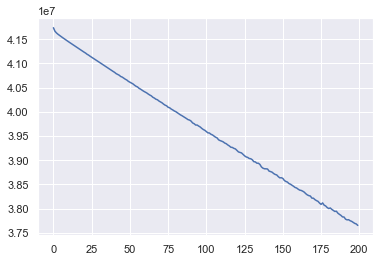

In [88]:
fig = plt.figure()
plt.plot(history.history['loss'], label="loss")
plt.plot(history.history['val_loss'], label="val_loss")
plt.legend()
plt.show()

In [84]:
def model_forecast(model, series, window_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.batch(SIZE).prefetch(1)
  forecast = model.predict(ds)
  return forecast

##### Data Preparation

In [85]:
window = 45

# # Split 80/20 into train/test data
last = int(len(scaled_df.Sales)/5.0)
Xtrain = scaled_df.Sales[:-last]
Xtest = scaled_df.Sales[-last-window:]

# # Store window number of points as a sequence
xin = []
next_X = []
for i in range(window, len(Xtrain)):
    try:
        xin.append(Xtrain[i-window:i])
        next_X.append(Xtrain[i])
    except Exception as e:
        print(f'i value : {i}')
        exit(0)

# Reshape data to format for LSTM
xin, next_X = np.array(xin), np.array(next_X)
xin = xin.reshape(xin.shape[0], xin.shape[1], 1)

In [86]:
# Initialize LSTM model
m = Sequential()
m.add(LSTM(units=50, return_sequences=True, input_shape=(xin.shape[1], 1)))
m.add(Dropout(0.2))
m.add(LSTM(units=50))
m.add(Dropout(0.2))
m.add(Dense(units=1))
m.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse', 'mae'])

In [36]:
#training
# Fit LSTM model
history = m.fit(xin, next_X, epochs=200, batch_size=20, verbose=0)

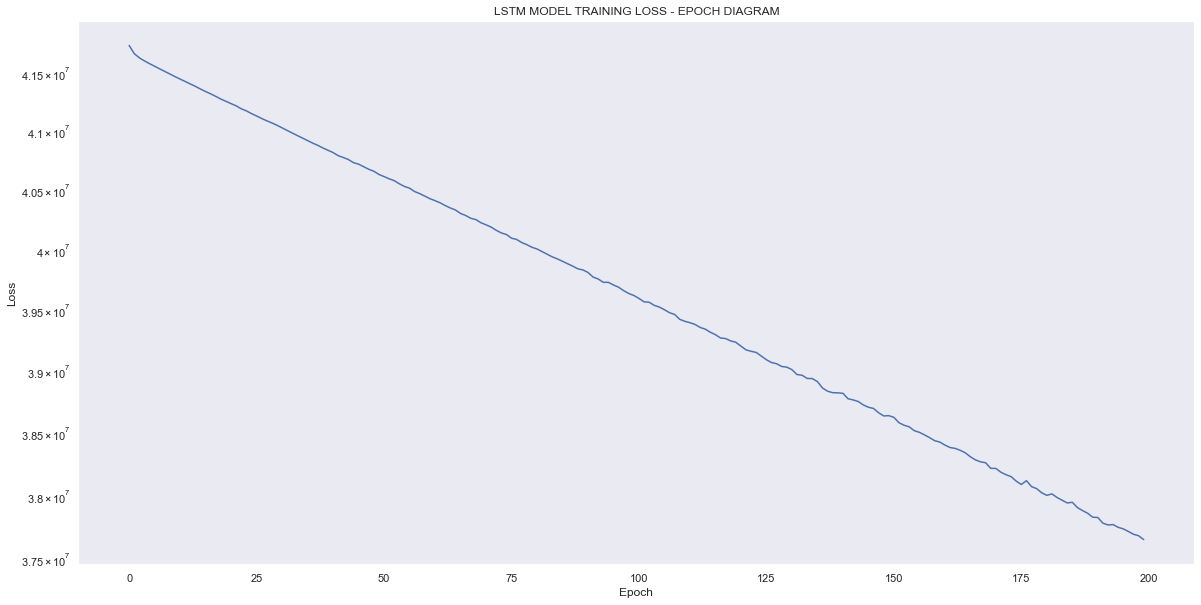

In [87]:
plt.figure(figsize=(20, 10))
plt.grid()
plt.title('LSTM MODEL TRAINING LOSS - EPOCH DIAGRAM')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.semilogy(history.history['loss'])

In [38]:
history.history['loss'][-1]

37653192.0

##### Prediction

6/6 [==============================] - 3s 30ms/step


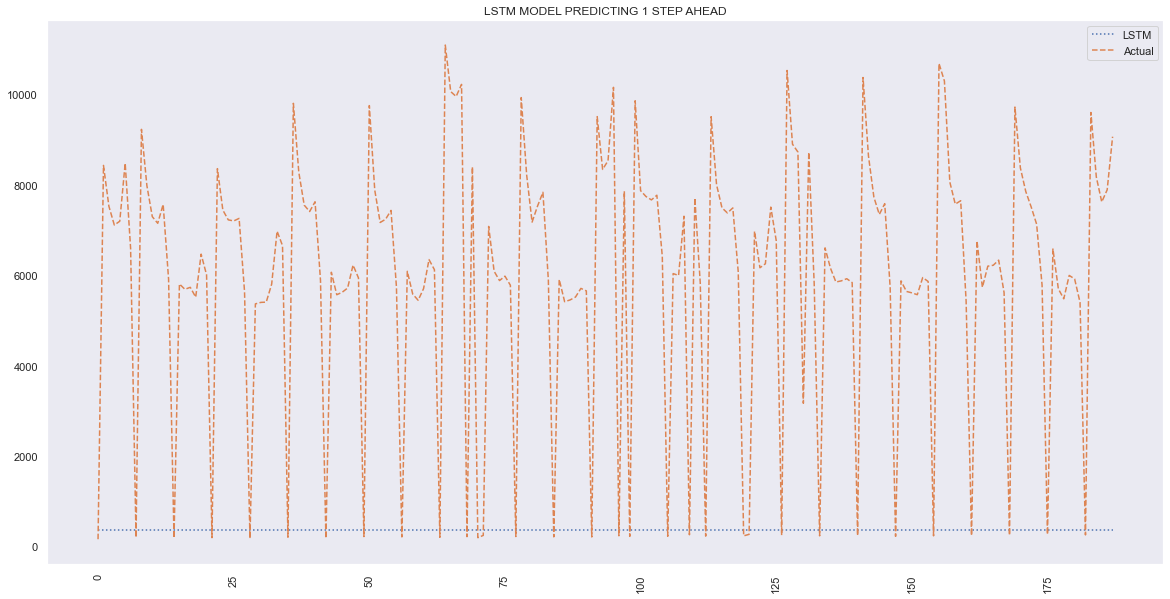

In [40]:
# Store "window" points as a sequence
xin = []
next_X1 = []
for i in range(window, len(Xtest)):
    xin.append(Xtest[i-window:i])
    next_X1.append(Xtest[i])

# Reshape data to format for LSTM
xin, next_X1 = np.array(xin), np.array(next_X1)
xin = xin.reshape((xin.shape[0], xin.shape[1], 1))

# Predict the next value (1 step ahead)
X_pred = m.predict(xin)

# Plot prediction vs actual for test data
plt.figure(figsize=(20, 10))
plt.title('LSTM MODEL PREDICTING 1 STEP AHEAD')
plt.xticks(rotation=90)
plt.grid()
plt.plot(X_pred, ':', label='LSTM')
plt.plot(next_X1, '--', label='Actual')
plt.legend()

###### Validation

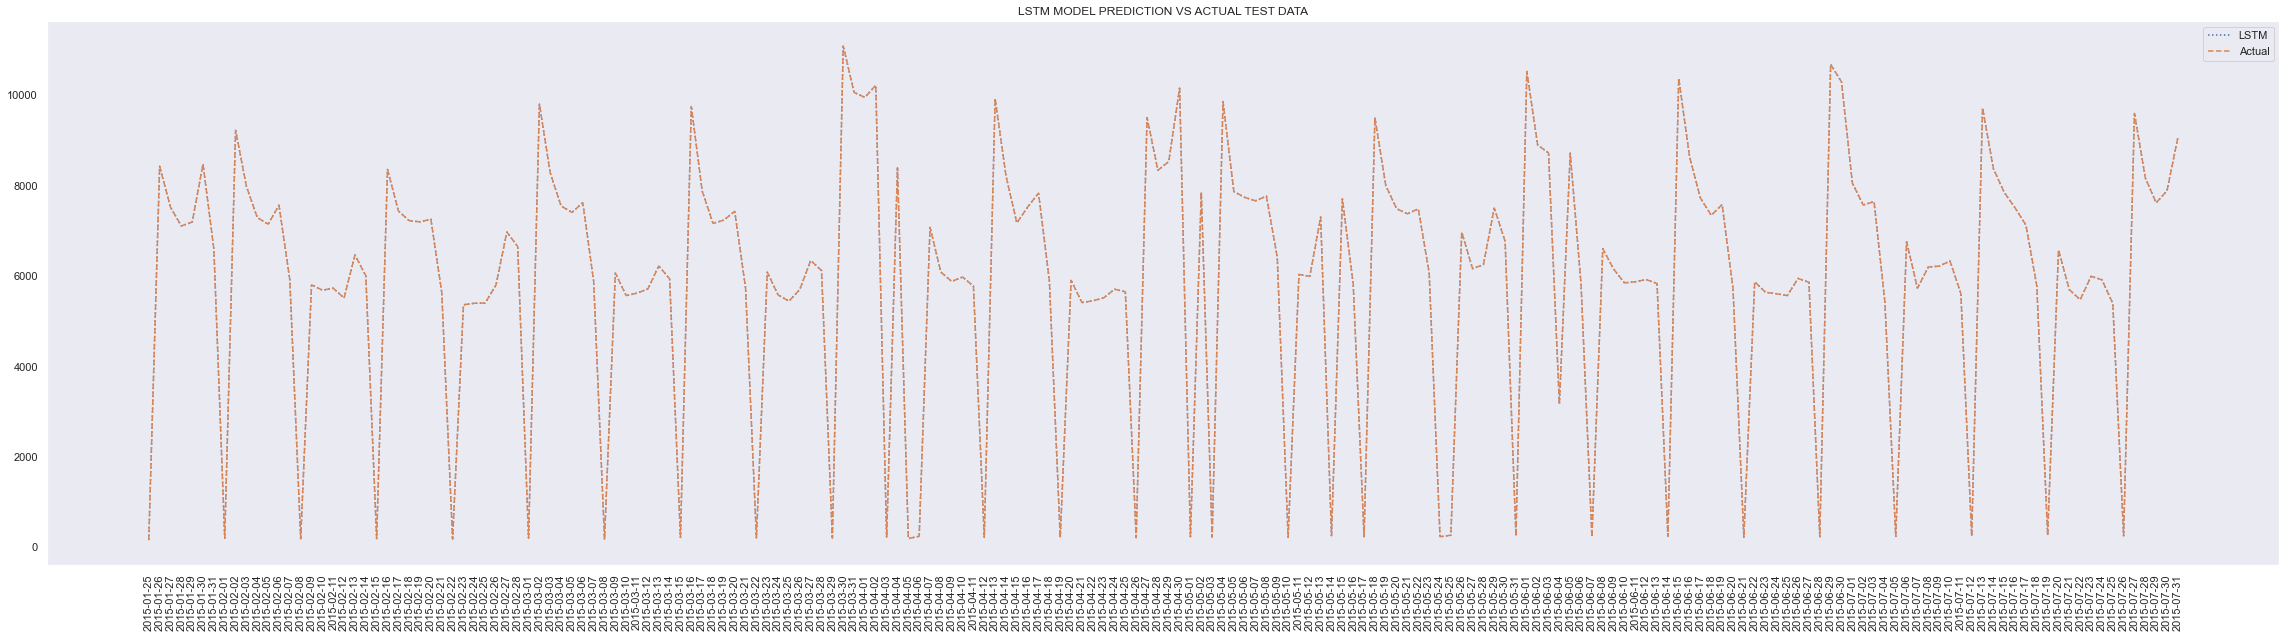

In [41]:
# Using predicted values to predict next step
X_pred = Xtest.copy()

# Plot prediction vs actual for test data
plt.figure(figsize=(40,10))
plt.title('LSTM MODEL PREDICTION VS ACTUAL TEST DATA')
plt.xticks(rotation=90)
plt.grid()
plt.plot(X_pred[window:], ':', label='LSTM')
plt.plot(next_X1, '--', label='Actual')
plt.legend()

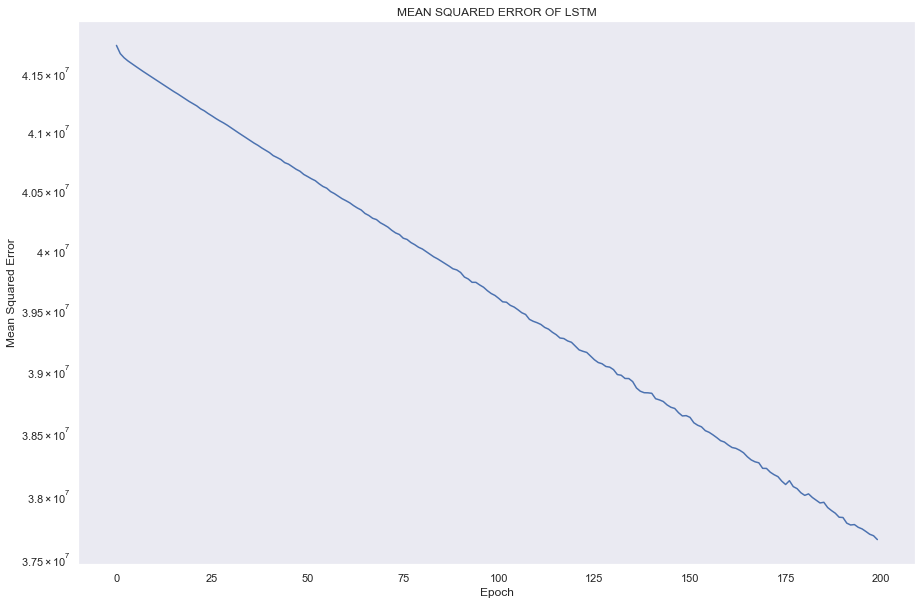

In [42]:
plt.figure(figsize=(15, 10))
plt.grid()
plt.title('MEAN SQUARED ERROR OF LSTM')
plt.ylabel('Mean Squared Error')
plt.xlabel('Epoch')
plt.semilogy(history.history['mse'])

In [43]:
history.history['mse'][-1]

37653192.0

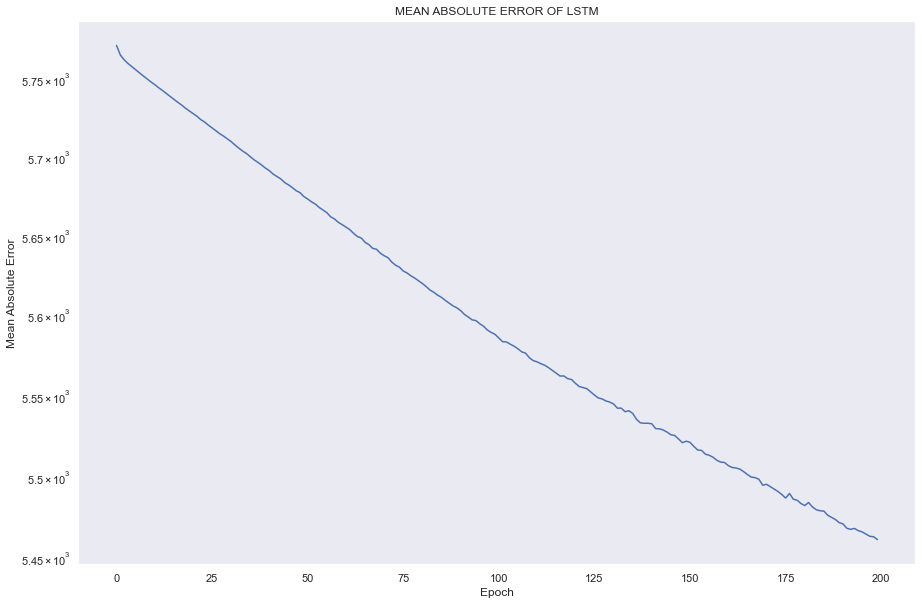

In [44]:
plt.figure(figsize=(15, 10))
plt.grid()
plt.title('MEAN ABSOLUTE ERROR OF LSTM')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epoch')
plt.semilogy(history.history['mae'])